In this notebook we will reproduce the results for the transfer of a single particle in a three level system in a $\Lambda$-configuration. The particle will be initialized on the left-most level $\left(|1\rangle\right)$, and the target is to transfer it to the right side $\left(|3\rangle\right)$, with minimal population in the intermediate level $\left(|2\rangle\right)$. In this example, all the levels will be in resonance, so that the one-photon and two-photon detuning are zero. The coupling between levels are modified with a Stockes and Pump frequency, which will be the driving parameter.

The results to reproduce are those given in [Y. Ban, et. al, Nanotechnology **29**, 505201 (2018)](https://iopscience.iop.org/article/10.1088/1361-6528/aae0ce), Fig. 3.

In [1]:
# Import relevant functions and libraries

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from joblib import Parallel, delayed, parallel
from tqdm.auto import tqdm
import contextlib

The Hamiltonian, written on the basis $\left\{|1\rangle, |2\rangle, |3\rangle\right\}$ reads as ($\hbar=1$)

$$
H(t) = \left(
\begin{array}{ccc}
0 & \Omega_{12}(t) & 0 \\
\Omega_{12}(t) & 0 & \Omega_{23}(t) \\
0 & \Omega{23}(t) & 0
\end{array}\right).
$$

In [3]:
def hamiltonian_factory(Omega12, Omega23):
    """Hamiltonian for a three level system in a Lambda-configuration, with one- and  two-photon detunings equals to 0."""
    H = np.zeros((3, 3), dtype=complex)
    
    H[0, 0:] = [0, Omega12, 0]
    H[1, 1:] = [0, Omega23]
    H[2, 2:] = [0]
    
    H += H.T.conjugate() - np.diag(np.diag(H))
    return qt.Qobj(H)

The transfer protocols is based on Shortcuts to Adiabaticity (STA), in particular on the Inverse Engeneering (IE) scheme. In this protocol, a time depepende wave function is parametriced with some anstaz, and the analytically solve the time-dependent Schrödinger equation in order to solve the time dependence of the driving parameters. This parametrization is defined as 

$$
|\Psi(t)\rangle = \cos\chi\cos\eta |1\rangle - i\sin\eta|2\rangle - \sin\chi\cos\eta|3\rangle,
$$
where $\chi(t)$ and $\eta(t)$ are some auxiliar function to be defined latter. By solving the Schrödinger equation we obtain the condition

$$
\begin{aligned}
\Omega_{12} &= \cos(\chi)\dot{\eta}+\cot(\eta)\sin(\chi)\dot{\chi},\\
\Omega_{23} &= -\sin(\chi)\dot{\eta}+\cot(\eta)\cos(\chi)\dot{\chi}. \\
\end{aligned}
$$
The auxiliar function must fulfill some given boundary condition at the begining and the end of the protocol (see ref for more details). The chosen parametrization is given in terms of the modfied Gutman 1-2 trajectory
$$
\begin{aligned}
\chi(t) &= \frac{\pi t}{2t_f}-\frac{1}{3}\sin\left(\frac{2\pi t}{t_f}\right) + \frac{1}{24}\sin\left(\frac{4\pi t}{t_f}\right),\\
\eta(t) &= \arctan(\dot{\chi}/\alpha_0),
\end{aligned}
$$
with $\alpha_0$ a parameters that defined the maximal population on the middle site.

In [4]:
def auxiliar_chi(times):
    tf = times[-1]
    t_prime = times / tf
    
    return np.pi * t_prime / 2 - 1 / 3 * np.sin(2 * np.pi * t_prime) + 1 / 24 * np.sin(4 * np.pi * t_prime)

def auxiliar_eta(d_chi, alpha_0):
    return np.arctan(d_chi / alpha_0)

def STA_pulse(times, alpha_0):
    """STA pulses based on IE and a Rutinger 1-3 trajectory."""
    chi = auxiliar_chi(times)
    d_chi = np.gradient(chi, times)
    
    eta = auxiliar_eta(d_chi, alpha_0)
    d_eta = np.gradient(eta, times)
    
    Omega_12 = np.cos(chi) * d_eta + np.sin(chi) * d_chi / (np.tan(eta) + 1e-15)
    Omega_23 = -np.sin(chi) * d_eta + np.cos(chi) * d_chi / (np.tan(eta) + 1e-15)
    
    return Omega_12, Omega_23

In [7]:
Omega_0 = 6
alpha_0 = 40
tf = 1 * 2 * np.pi / Omega_0
times = np.linspace(0, tf, 1000)

chi = auxiliar_chi(times)
d_chi = np.gradient(chi, times)
eta = auxiliar_eta(d_chi, alpha_0)

Omega_12, Omega_23 = STA_pulse(times, alpha_0)

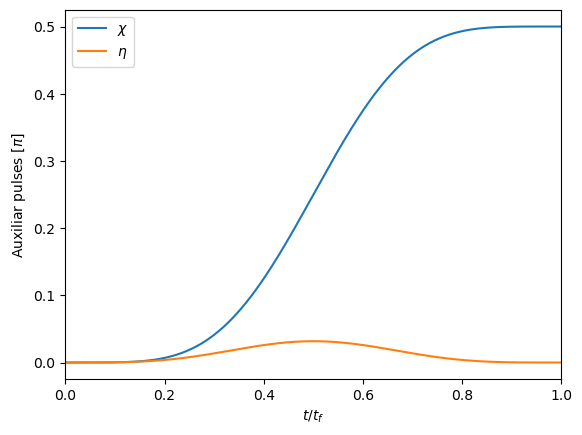

In [8]:
fig, ax = plt.subplots()

ax.plot(times / tf, chi / np.pi, label=r'$\chi$')
ax.plot(times / tf, eta / np.pi, label=r'$\eta$')

ax.set_xlim(0, 1)
ax.set_xlabel(r'$t/t_f$')
ax.set_ylabel(r'Auxiliar pulses $[\pi]$')

ax.legend();

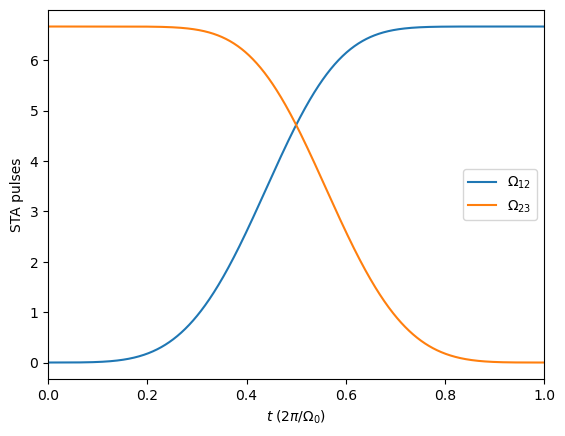

In [9]:
fig, ax = plt.subplots()

ax.plot(times / (2 * np.pi / Omega_0), Omega_12 / Omega_0, label=r'$\Omega_{12}$')
ax.plot(times / (2 * np.pi / Omega_0), Omega_23 / Omega_0, label=r'$\Omega_{23}$')

ax.set_xlim(0, tf / (2 * np.pi / Omega_0))
ax.set_xlabel(r'$t \; (2\pi/\Omega_0)$')
ax.set_ylabel('STA pulses')

ax.legend();

We simulate the time evolution with no coupling to any eviroment, so we have to solve the time-dependent Schrödinger equation.

In [10]:
def solve_dynamics(alpha_0):
    """Solve the dynamics under STA, with no dephasing or losses."""
    psi_0 = qt.basis(3, 0)
    
    pulses = STA_pulse(times, alpha_0)
    
    H_12 = [hamiltonian_factory(1, 0), pulses[0]]
    H_23 = [hamiltonian_factory(0, 1), pulses[1]]
    H_total = [H_12, H_23]
    
    psi_t = qt.sesolve(H_total, psi_0, times).states
    
    return np.array(psi_t).reshape(len(times), 3)

In [11]:
psi_t = solve_dynamics(alpha_0)
populations = np.abs(psi_t) ** 2

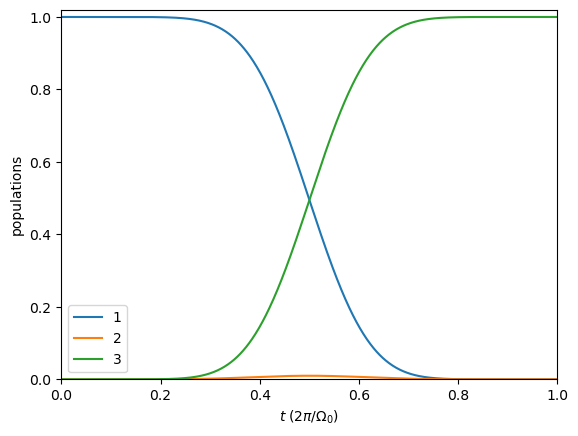

In [12]:
fig, ax = plt.subplots()

for i, population in enumerate(populations.T):
    ax.plot(times / (2 * np.pi / Omega_0), population, label='{}'.format(i + 1))
    
ax.legend()
ax.set_xlim(0, tf / (2 * np.pi / Omega_0))
ax.set_ylim(0, 1.02)
ax.set_xlabel(r'$t \; (2\pi/\Omega_0)$')
ax.set_ylabel('populations');

In [13]:
def compute_P2_maximum(alpha_0):
    """Obtain the population for each level after a STA."""
    psi_t = solve_dynamics(alpha_0)
    P2 = np.abs(psi_t[:, 1]) ** 2
    return np.max(P2)

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar."""
    class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = parallel.BatchCompletionCallBack
    parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [14]:
n_alpha = 100
alphas = np.linspace(10, 100, n_alpha)

with tqdm_joblib(tqdm(range(n_alpha), desc="Computing STA transfer")) as pbar:
    P2_max = Parallel(n_jobs=-1)(delayed(compute_P2_maximum)(alphas[j]) for j in range(n_alpha))
    
P2_max = np.array(P2_max)

Computing STA transfer:   0%|          | 0/100 [00:00<?, ?it/s]

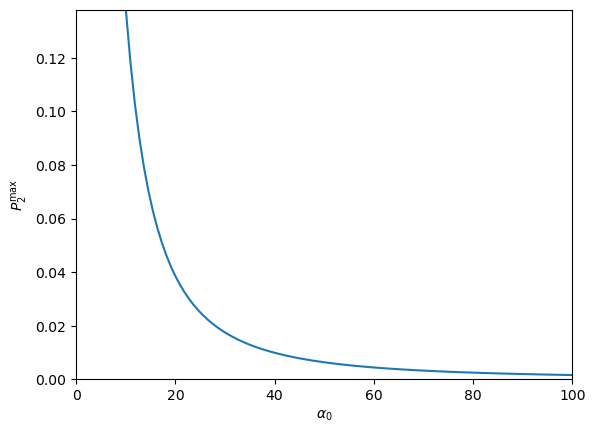

In [15]:
fig, ax = plt.subplots()
ax.plot(alphas, P2_max)

ax.set_xlim(0, max(alphas))
ax.set_ylim(0, max(P2_max))

ax.set_xlabel(r'$\alpha_0$')
ax.set_ylabel(r'$P_2^\max$');